# NPZD parameter estimation prototype

 * A simple differential evolution (DE) algorithm is used to estimate/optimize select parameters.
 * A normalized $\chi^2$ cost function is used to measure model-observation misfit: $$\frac{1}{n}\sum_{k=1}^n \left(\frac{x_k - y_k}{\sigma_k}\right)^2$$
 * The fitness term, maximised in the differential evolution is the negative cost function.

### preparation
Import packages, set default plotting parameters, and specify some colors.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 20

# colorblind-friendly colors for N, P, Z, D
colors = {
    'N': '#4477AA', 
    'P': '#228833',
    'Z': '#EE6677', 
    'D': '#CCBB44',
}

### settings changeable by the user

Below are the main settings that determine the parameter estimation configuration.

`np.random.seed(seed)`: Set an integer seed value for the pseudo-random number generator. Comment out this line to not set a seed and obtain different results every time the notebook is run.

`parameters_true`: Contains the "true" values of the parameters that are used to determine the "truth", that is, the true state of the modeled system. `parameters_true` needs to contain all model parameters, even those that are not estimated/optimized.

`parameters_prior`: Contains the prior estimate of the parameters that are estimated/optimized, and thus the starting point of the parameter estimation/optimization. Parameters not listed in `parameters_prior` are not estimated and assumed to be constant, their values are kept at the values specified in `parameters_true`.

`parameters_uncertainty`: Contains the uncertainty for each parameter in `parameters_prior`. The initial sample or "population" of parameter values in the optimization algorithm is drawn from a normal distribution using the value in `parameters_prior` as mean and value in `parameters_uncertainty` as the standard deviation for each parameter that is being estimated.

`t`: Time vector determining the length and time-stepping for each model simulation. It is recommended to start t at 0 and use a time stepping of 1 day.

`obs_info`: Contains a one or multiple entries that determine the observations used in the parameter estimation. Each entry corresponds to an observation and needs to contain 3 values:
 1. A time index for t (integer), setting the time when the observation was taken.
 2. The observed variable ('N', 'P', 'Z', or 'D').
 3. The uncertainty of the observation.

The observations are then generated from the "truth" by indexing it at the specified time index for the specified variable and adding normal pseudo-random noise with a zero mean and standard deviation based on the specified uncertainty. To not add noise to the observations, see `perfect_observations` below.

`perfect_observations`: If set to `False` (default), the observation uncertainty in `obs_info` is used to add noise to the observations. If set to `True`, no noise is added, and the "true" state is observed perfectly. Note, that the observation uncertainty is always used in the computation of the cost and fitness function.

`perfect_initial_conditions`: If set to `True` (default), the "truth" and all other model simulations use the same initial condition, that is, there is perfect knowledge of the initial conditions. If set to `False`, a new, imperfect initial condition is created from the "true" initial conditions and used for all model simulations except for the "truth". Note, that only parameter values are estimated in this notebook, so an imperfect state adds uncertainty to the parameter estimation procedure.

`x0_true`: Specifies the "true" initial conditions.

`x0_uncertainty`: Specifies the uncertainty in the inititial conditions, if `perfect_initial_conditions` is set to `False`. It acts as the standard deviation of pseudo-random normal, zero-mean noise that is added to `x0_true` to create the imperfect intial conditions, if `perfect_initial_conditions` is set to `False`.

`npop`: The population or sample size of the parameter estimation/optimization procedure.

`nparents`: The number of parents (parameter sets) in the population of the parameter estimation/optimization procedure, used to create offspring (new parameter sets).

`ngenerations`: The number of generations (iterations) to run the estimation/optimization procedure.

`show_cost`: If set to `True`, compute and display gridded cost function values in one of the plots. This can take a long time, and can be turned off by setting `show_cost` to `False`.

In [2]:
# set seed of pseudo-random number generator for reproducible results
np.random.seed(20220217)

# true parameter values
parameters_true = {
    'vmax': 0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat': 0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz': 0.02,        # zooplankton grazing rate
    'mortP': 0.02,       # phytoplankton mortality rate
    'mortZ': 0.03,       # zooplankton mortality rate
    'reminrate': 0.1,    # remineralization rate
}

# select which parameters to estimate and what their prior values should be
parameters_prior = {
    'vmax': 0.1,
    'nuthalfsat': 0.4,
    'graz': 0.01,
}

# uncertaiinty in the prior parameter values
parameters_uncertainty = {
    'vmax': 0.1,
    'nuthalfsat': 0.1,
    'graz': 0.01,
}

# initialize time vector (default: 2 years)
t = np.arange(0.0, 2 * 365.0, 1.0)

# select when to observe state in time, which variable, and with which uncertainty
obs_info = [
# each entry contains
# (time (index for t, integer), variable ('N', 'P', 'Z', or 'D'),  observation uncertainty)
    (100, 'N', 0.01),
    (200, 'N', 0.01),
    (150, 'P', 0.02),
    (200, 'P', 0.02),
    (250, 'P', 0.02),
    (300, 'P', 0.02),
    (350, 'P', 0.02),
    (400, 'P', 0.02),
]

perfect_observations = False

perfect_initial_conditions = True

# initial conditions
x0_true = np.array((0.6, 0.15, 0.2, 0.05))

# initial conditions
x0_uncertainty = np.array((0.01, 0.01, 0.01, 0.01))

# select population size for the optimization algorithm
npop = 50

# select the parent size for the optimization algorithm
nparents = npop // 2

# select the number of generations (iterations) of the optimization algorithm
ngenerations = 20

# show cost function grid
show_cost = True

### evaluate and check user input

In [3]:
if perfect_initial_conditions:
    x0_estimate = x0_true.copy()
else:
    x0_estimate = np.maximum(1e-6, x0_true + x0_uncertainty * np.random.normal(size=x0_true.size))
    
# TODO more code to check user input required

### model code

In [4]:
# model 
def npzd(x, t, parameters, light):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    '''
    n, p, z, d = np.maximum(x, 0.0)
    
    growth = parameters['vmax'] * n / (parameters['nuthalfsat'] + n) * light(t) * p
    grazing = parameters['graz'] * p * z
    p_loss = parameters['mortP'] * p
    z_loss = parameters['mortZ'] * z * z
    remin = parameters['reminrate'] * d
    
    return np.array((-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin))

# light function returning irradiance at time t
def light(t):
    return 1.0 + 0.5*(0.8 * np.sin(np.pi*((t-81.25)/182.5)) - 0.8)

### helper functions to run model

In [5]:
parameter_minval = 1e-6

def run_model(parameter_values=None, x0=None):
    if x0 is None:
        x0 = x0_true
    parameters_run = parameters_true.copy()
    if parameter_values is not None:
        if isinstance(parameter_values, dict):
            parameters_run.update(parameter_values)
        else:
            assert len(parameter_values) == len(parameters_prior), ('The number of input parameters must'
                                                                    f' be {len(parameters_prior)}.')
            for p, v in zip(parameters_prior, parameter_values):
                parameters_run[p] = v
    return odeint(npzd, x0, t, args=(parameters_run, light))

def observation_operator(trajectory, obs_info=obs_info):
    return np.array([trajectory[oi[0], 'NPZD'.index(oi[1])] for oi in obs_info])

### generate synthetic data from "true" parameters (`parameters_true`)

In [6]:
npar = len(parameters_prior)
nobs = len(obs_info)

# use model to generate the true state and add observation error to create synthetic observations
state_true = observation_operator(run_model())

# extract observation uncertainty
obs_uncertainty = np.array([oi[2] for oi in obs_info])

# generate observations
if perfect_observations:
    obs = state_true
else:
    obs = state_true + obs_uncertainty * np.random.normal(size=state_true.size)

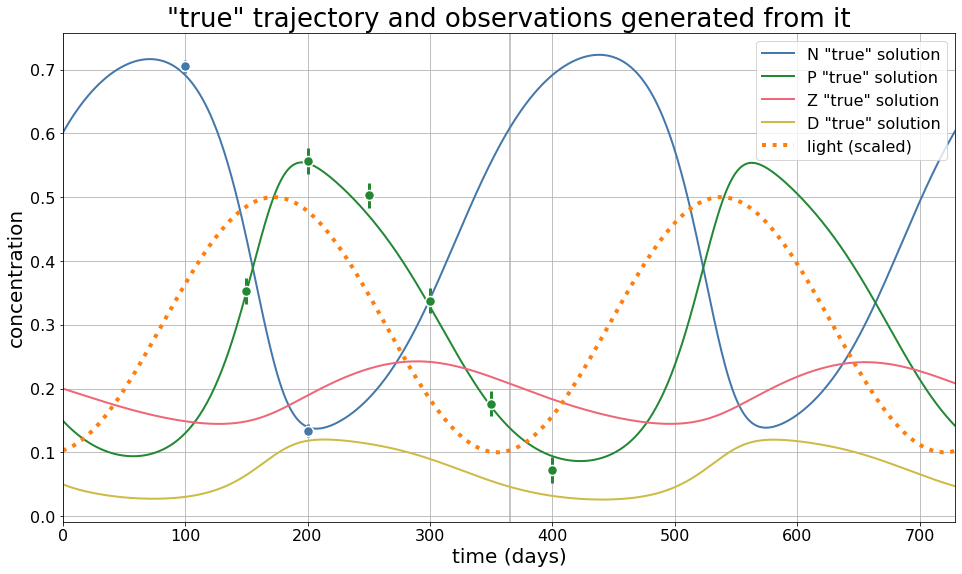

In [7]:
fig, ax = plt.subplots()

trajectory = run_model()
for i, name in enumerate(('N', 'P', 'Z', 'D')):
    ax.plot(t, trajectory[:,i], color=colors[name], lw=2,
            label=f'{name} "true" solution')

for oi, y in zip(obs_info, obs):
    ax.errorbar(x=t[oi[0]], y=y, yerr=oi[2], color=colors[oi[1]], marker='o', 
                markeredgecolor='white', markeredgewidth=1.5, lw=3, markersize=10)
        
ax.axvline(365, color='0.7', zorder=0)
ax.plot(t, 0.5 * light(t), linestyle=':', color='#ff7f0e', label='light (scaled)', lw=4)

ax.set(title='"true" trajectory and observations generated from it', 
       xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
ax.grid(True)
ax.legend(loc='upper right')
None

### create and plot initial population

In [8]:
# generate the prior ensemble of parameters
pop_mean = np.array([parameters_prior[p] for p in parameters_prior.keys()])
prior_uncertainty = np.array([parameters_uncertainty[p] for p in parameters_prior.keys()])

pop = np.maximum(parameter_minval, pop_mean + prior_uncertainty * np.random.normal(size=(npop, npar)))
assert not np.any(np.isnan(pop)), 'Pop trouble'.format(igen)

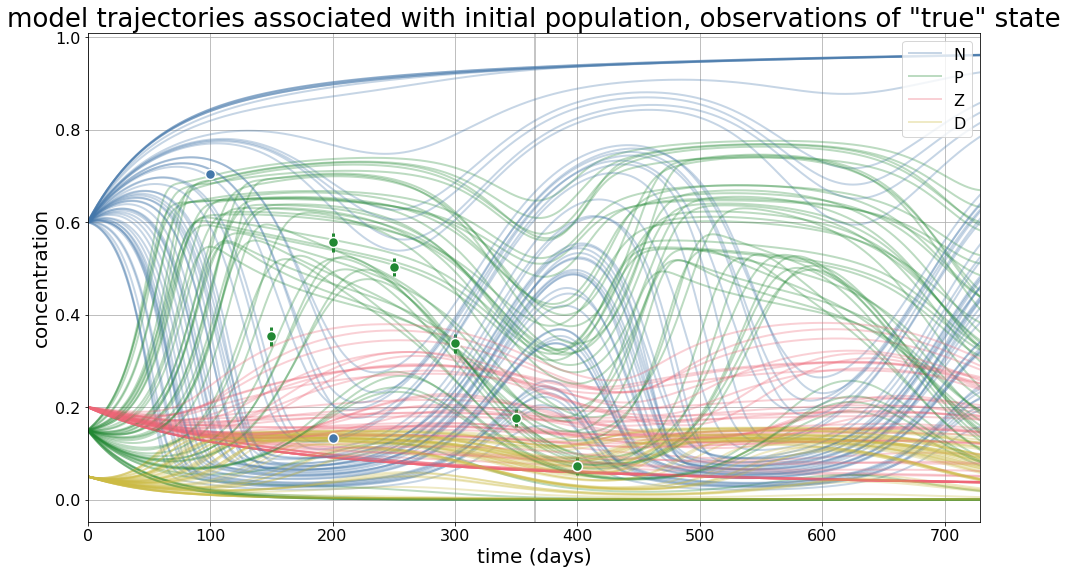

In [9]:
# upper limit on number of trajectories to include in plot
max_plot = 50

fig, ax = plt.subplots()
for ipop, params in enumerate(pop[:max_plot, :]):
    trajectory = run_model(parameter_values=params, x0=x0_estimate)
    label = None
    for i, name in enumerate(('N','P','Z', 'D')):
        if ipop == 0:
            label = name
        ax.plot(t, trajectory[:,i], color=colors[name], label=label, lw=2, alpha=0.3)

for oi, y in zip(obs_info, obs):
    ax.errorbar(x=t[oi[0]], y=y, yerr=oi[2], color=colors[oi[1]], marker='o', 
                markeredgecolor='white', markeredgewidth=1.5, lw=3, markersize=10)
        
ax.axvline(365, color='0.7', zorder=0)

ax.set(title='model trajectories associated with initial population, observations of "true" state', 
       xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
ax.grid(True)
ax.legend(loc='upper right')

None

### code to perform differential evolution parameter estimation

In [10]:
def compute_fitness(pop, x0):
    if hasattr(pop, 'shape'):
        # array input
        fitness = np.empty(pop.shape[0])
    else:
        # list etc
        fitness = np.empty(len(pop))
    for ipop, params in enumerate(pop):
        hx = observation_operator(run_model(parameter_values=params, x0=x0))
        fitness[ipop] = -np.mean(((hx - obs) / obs_uncertainty)**2)
    return fitness


def recombine(parents, noffspring):
    nparents = parents.shape[0]
    offspring = np.empty((noffspring, parents.shape[1]))
    for ioffspring in range(noffspring):
        i0 = np.random.randint(0, nparents)
        i1 = np.random.randint(0, nparents-1)
        i2 = np.random.randint(0, nparents-2)
        
        i1 += (i1 >= i0)
        i2 += (i2 >= i0)
        i2 += (i2 >= i1)
        
        offspring[ioffspring, :] = np.maximum(parameter_minval, parents[i0, :] + 0.1 * (parents[i1, :] - parents[i2, :]))
        
    return offspring


fitness = compute_fitness(pop, x0_estimate)
noffspring = npop - nparents

pop_highest_fitness = np.empty((ngenerations + 1, pop.shape[1]))
highest_fitness = np.empty(ngenerations + 1)

for igen in range(ngenerations):
    index = np.argsort(fitness)
    
    pop_highest_fitness[igen] = pop[index[-1], :]
    highest_fitness[igen] = fitness[index[-1]]
    
    index_offspring = index[:noffspring]
    index_parent = index[noffspring:]
    assert not np.any(np.isnan(pop)), 'Pop trouble igen={}, before'.format(igen)
    pop[index_offspring, :] = recombine(parents=pop[index_parent, :], noffspring=noffspring)
    assert not np.any(np.isnan(pop)), 'Pop trouble igen={}, after'.format(igen)
    
    fitness[index_offspring] = compute_fitness(pop[index_offspring, :], x0_estimate)
    
index = np.argsort(fitness)
pop_highest_fitness[-1, :] = pop[index[-1], :]
highest_fitness[-1] = fitness[index[-1]]

### plot cost reduction and estimated parameter values as a function of iteration

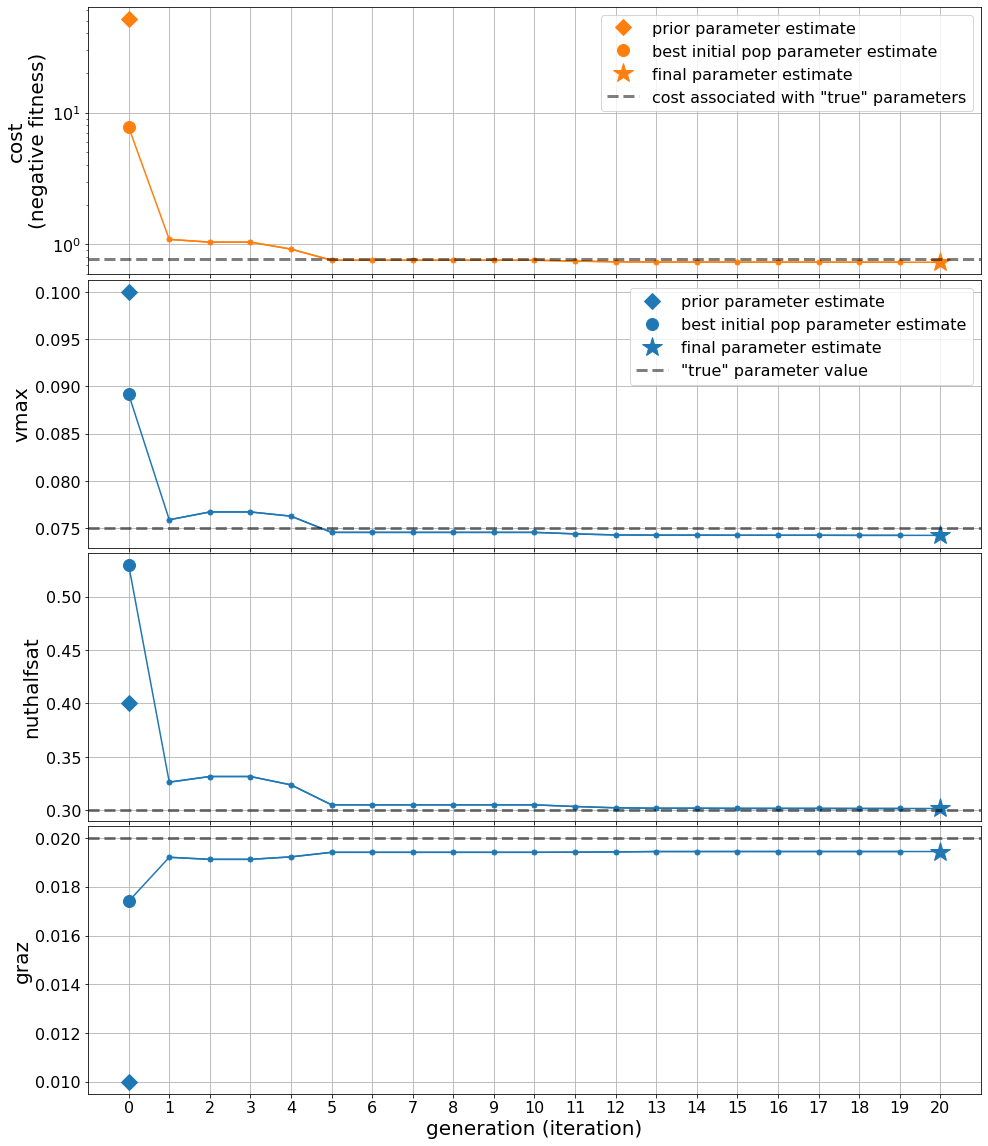

In [11]:
nrows = npar + 1
fig, axs = plt.subplots(nrows=nrows, sharex=True, figsize=(16, 5*nrows), gridspec_kw={'hspace': 0.02})

x = np.arange(ngenerations + 1)

for i, (ax, paramdev, name) in enumerate(zip(axs[1:], pop_highest_fitness.T, parameters_prior)):
    ax.plot(x, paramdev, color='tab:blue')
    ax.plot(x[1:-1], paramdev[1:-1], marker='o', markersize=5, color='tab:blue')
    ax.plot(0, parameters_prior[name], color='tab:blue', linestyle='none', 
            marker='D', markersize=12, label='prior parameter estimate')
    ax.plot(x[0], paramdev[0], color='tab:blue', linestyle='none', 
            marker='o', markersize=12, label='best initial pop parameter estimate')
    ax.plot(x[-1], paramdev[-1], color='tab:blue', linestyle='none', 
            marker='*', markersize=20, label='final parameter estimate')
    ax.axhline(parameters_true[name], ls='--', lw=3, alpha=0.5, label='"true" parameter value', color='black')
    ax.set(ylabel=name)
    ax.grid(True)
    if i == 0:
        ax.legend()
    
ax = axs[0]
color = ax.plot(x, -highest_fitness, color='tab:orange')[0].get_color()
ax.plot(x[1:-1], -highest_fitness[1:-1], marker='o', markersize=5, color=color)
ax.plot(0, -compute_fitness([parameters_prior], x0_estimate), color=color, linestyle='none', marker='D', 
        markersize=12, label='prior parameter estimate')
ax.plot(x[0], -highest_fitness[0], color=color, linestyle='none', marker='o', markersize=12, 
        label='best initial pop parameter estimate')
ax.plot(x[-1], -highest_fitness[-1], color=color, linestyle='none',marker='*', markersize=20, 
        label='final parameter estimate')
if not perfect_observations:
    ax.axhline(-compute_fitness([None], x0_true), ls='--', lw=3, alpha=0.5, color='black', 
               label='cost associated with "true" parameters' + 
               (' ("true" initial conditions)', '')[perfect_initial_conditions])
    if not perfect_initial_conditions:
        ax.axhline(-compute_fitness([None], x0_estimate), ls=':', lw=3, alpha=0.5, color='black', 
                   label='cost associated with "true" parameters (imperfect initial conditions)')
elif not perfect_initial_conditions:
    ax.axhline(-compute_fitness([None], x0_estimate), ls='--', lw=3, alpha=0.5, color='black', 
               label='cost associated with "true" parameters and true initial conditions')

ax.grid(True)
ax.set(xticks=x, ylabel='cost\n(negative fitness)', yscale='log')
ax.legend()

axs[-1].set(xlabel='generation (iteration)')
None

### compute gridded cost function (if desired)

**Note:** If this step takes to much time, set `show_cost` to `False`.

In [12]:
parameters_list = list(parameters_prior)

include_prior = True

if show_cost:
    res = 20
    cost_slices = {}
    cost_grid = {}
    for p0 in parameters_prior:
        for p1 in parameters_prior:
            if p0 >= p1:
                continue
            key = tuple((p0, p1))
            if key in cost_slices:
                continue
            
            for p in (p0, p1):
                if p in cost_grid:
                    continue
                i = parameters_list.index(p)
                p_range = np.array([min(np.min(pop_highest_fitness[:, i]), parameters_true[p]), 
                                    max(np.max(pop_highest_fitness[:, i]), parameters_true[p])])
                if include_prior:
                    p_range[0] = min(p_range[0], parameters_prior[p])
                    p_range[1] = max(p_range[1], parameters_prior[p])
                cost_grid[p] = np.linspace(p_range[0], p_range[1], res)
            
            cost_slices[key] = np.empty((res, res))
            for i0, v0 in enumerate(cost_grid[p0]):
                for i1, v1 in enumerate(cost_grid[p1]):
                    cost_slices[key][i0, i1] = -compute_fitness([{p0: v0, p1: v1}], x0_estimate)

### plot the sequence of estimated paramater values in parameter space for each generation 

**Note:** When estimating/optimizing more than 2 parameters, the background cost function (only shown when `show_cost` is set to `True`) represents a 2-dimensional slice of the higher-dimensional cost function intersecting the "true" parameter values. The path, showing the sequence of estimated parameter values is projected onto each slice.

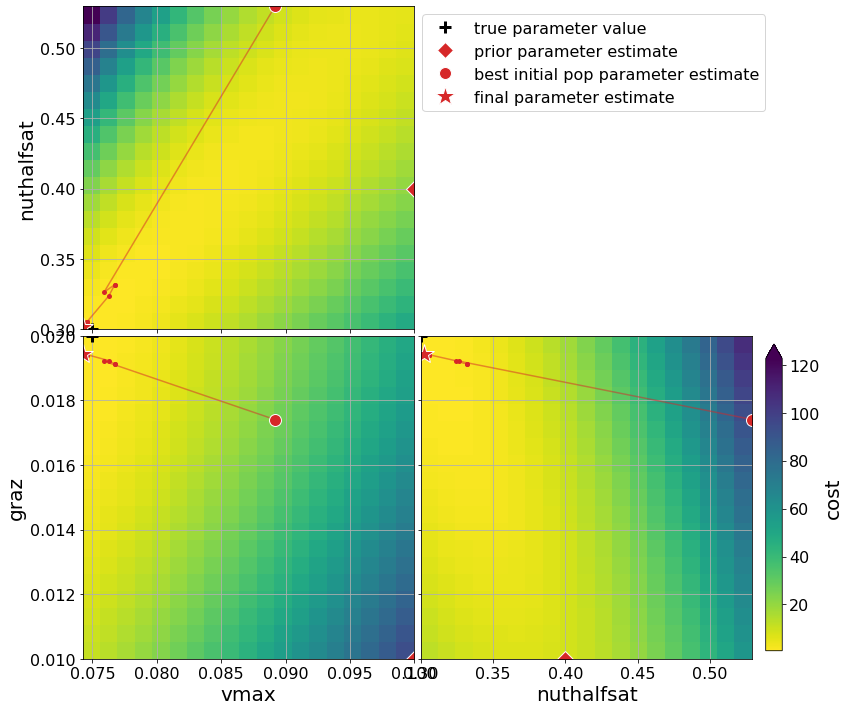

In [13]:
nrows = npar - 1
ncols = npar - 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), sharex='col', sharey='row', 
                        squeeze=False, gridspec_kw={'hspace': 0.02, 'wspace': 0.02})

parameter_names = {i: k for i, k in enumerate(parameters_prior)}
pcs = []
for icol, ix in enumerate(range(npar - 1)):
    for irow, iy in enumerate(range(1, npar)):
        ax = axs[irow, icol]
        if irow < icol:
            ax.set_visible(False)
            continue
            
        x_name = parameter_names[ix]
        y_name = parameter_names[iy]
        
        if irow == npar - 2:
            ax.set_xlabel(x_name)
        if icol == 0:
            ax.set_ylabel(y_name)
        
        ax.plot(parameters_true[parameter_names[ix]], parameters_true[parameter_names[iy]], marker='+', 
                linestyle='none', markersize=12, markeredgewidth=3, markeredgecolor='black', 
                label='true parameter value')
        ax.plot(pop_highest_fitness[:, ix], pop_highest_fitness[:, iy], color='tab:red', alpha=0.5)
        ax.plot(pop_highest_fitness[1:-1, ix], pop_highest_fitness[1:-1, iy], color='tab:red', marker='o', 
                markersize=5, mec='none', linestyle='none')
        ax.plot(parameters_prior[x_name], parameters_prior[y_name], color='tab:red', marker='D', 
                markersize=12, mec='white', linestyle='none', label='prior parameter estimate')
        ax.plot(pop_highest_fitness[0, ix], pop_highest_fitness[0, iy], color='tab:red', marker='o', 
                markersize=12, mec='white', linestyle='none', label='best initial pop parameter estimate')
        ax.plot(pop_highest_fitness[-1, ix], pop_highest_fitness[-1, iy], color='tab:red', 
                marker='*', markersize=20, mec='white', linestyle='none', label='final parameter estimate')
        
        if show_cost:
            if (x_name, y_name) in cost_slices:
                pcs.append(ax.pcolormesh(cost_grid[x_name], cost_grid[y_name], cost_slices[(x_name, y_name)].T, 
                                         shading='auto', cmap=mpl.cm.viridis_r))
            else:
                pcs.append(ax.pcolormesh(cost_grid[x_name], cost_grid[y_name], cost_slices[(y_name, x_name)], 
                                         shading='auto', cmap=mpl.cm.viridis_r))
                
        ax.grid(True)
        
        if irow == 0 and icol == 0:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 0, 1, 1))

if show_cost:
    # equalize color scale for background cost function across panels
    vmin = 100000.
    vmax = 0.
    for pc in pcs:
        vmin = min(vmin, pc.norm.vmin)
        vmax = max(vmax, pc.norm.vmax)
    for pc in pcs:
        pc.norm.vmin = vmin
        pc.norm.vmax = vmax
    
    ax = axs[1, 1]
    cax = ax.inset_axes([1.04, 0.025, 0.05, 0.95], transform=ax.transAxes)
    fig.colorbar(pcs[0], ax=ax, cax=cax, label='cost', extend='max')
None

### plot the "true" model trajectory and the trajectory associated with the estimated parameters for comparison

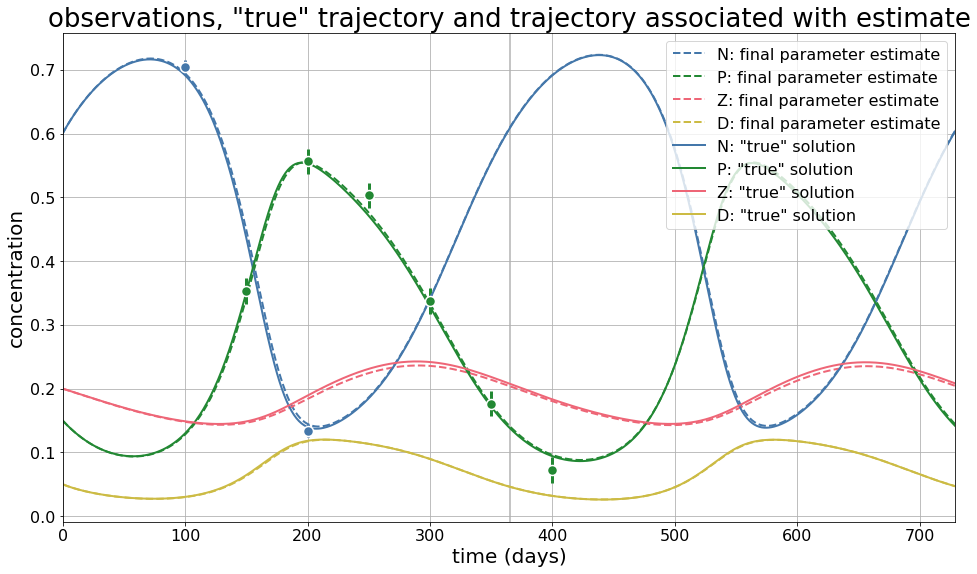

In [14]:
fig, ax = plt.subplots()

trajectory = run_model(parameter_values=pop_highest_fitness[-1, :], x0=x0_estimate)
for i, name in enumerate(('N', 'P', 'Z', 'D')):
    ax.plot(t, trajectory[:,i], color=colors[name], lw=2, linestyle='--',
            label=f'{name}: final parameter estimate')

trajectory = run_model()
for i, name in enumerate(('N', 'P', 'Z', 'D')):
    ax.plot(t, trajectory[:,i], color=colors[name], lw=2,
            label=f'{name}: "true" solution')

for oi, y in zip(obs_info, obs):
    ax.errorbar(x=t[oi[0]], y=y, yerr=oi[2], color=colors[oi[1]], marker='o', 
                markeredgecolor='white', markeredgewidth=1.5, lw=3, markersize=10)
        
ax.axvline(365, color='0.7', zorder=0)

ax.set(title='observations, "true" trajectory and trajectory associated with estimate', 
       xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
ax.grid(True)
ax.legend(loc='upper right')
None